# Feature-Engineering, Feature-Selection, Regression Analysis and Time-Series Analysis

The reason why we may want to predict the hourly carpark availability may be to ensure to that there is enough number of parking spaces available during a particular occasion or an event. 

This information will useful to an event planner or a wedding planner who is estimating the number of guests who require a parking space during the event. 

With a good forecasting model, it gives you the necessary information on how many vehicles can be accommodated in a particular area. It also provides information other parking availabilities just In case the location where an event is being held runs out of parking spaces. This allows the event planner to reserve parking spaces in other areas that it becomes less of hassle for the guests.

## Data Pre Processing

First we define the function to get the carpark availability data of a specific time from LTA's API.

In [1]:
import requests
import json
import pandas as pd
def get_data(year,month,day,hour,minute,second):
    year = str(year)
    month = str(month)
    day = str(day)
    hour = str(hour)
    minute = str(minute)
    second = str(second)
    
    site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month.zfill(2)}-{day.zfill(2)}T{hour.zfill(2)}%3A{minute.zfill(2)}%3A{second.zfill(2)}'
    print(site)
    response_API = requests.get(site)
    data = response_API.text
    data = json.loads(data)
    timestamp = data["items"][0]["timestamp"]
    print(timestamp)

    data = data["items"][0]["carpark_data"]
    with open("EE4211data.json", 'w') as fp:
        json.dump(data, fp)
    df = pd.read_json("EE4211data.json")
    for heading in ("total_lots","lot_type","lots_available"):
        df[heading] = df["carpark_info"].apply(lambda x: x[0][heading])
    df = df.drop(["carpark_info"], axis=1)
    return df

We utlize the above function to iteratively get the hourly data for the month of July and August 2022.

Note: there are no data from the API for the time of 0000hrs. Since this is consistent for all carparks, we will not be collecting the data points of all carparks for that timing as it will just be NULL. This is fine as it will not affect our results for the subsequent questions anyway.

This will give us a resultant dataframe of 23 x 31 = 713 hourly datapoints.

Data was saved to json for offline processing. The following code reads those json files into dataframes for the respective months. 

In [2]:
import json
import pandas as pd


df_august = pd.read_json('./august.json', 
                         lines=True)
df_july = pd.read_json('./july.json', 
                         lines=True)



Let us now check the number of rows and columns in the datasets to get a rough idea of how large the sets are. We also check if both the dataframes for July and August are of the same dimesnsion, so a useful comparision can be made between them. 

In [3]:
print("The dataframe shape of July", df_july.shape)
print("The dataframe shape of August", df_august.shape)

The dataframe shape of July (1968, 714)
The dataframe shape of August (1968, 714)


As we can see both dataframes have the same shape, with 1968 records and 713 attributes. Let us now take a brief look at our data set to know what we are working with.

In [4]:
df_july.head()

,carpark_number,1-1,2-1,3-1,4-1,5-1,6-1,7-1,8-1,9-1,...,14-31,15-31,16-31,17-31,18-31,19-31,20-31,21-31,22-31,23-31
0,HE12,56,56.0,56.0,56.0,56.0,27.0,27.0,27.0,27.0,...,28.0,23.0,23.0,21.0,17.0,18.0,17.0,41.0,59.0,63.0
1,HLM,482,482.0,479.0,482.0,482.0,475.0,464.0,398.0,308.0,...,195.0,277.0,348.0,385.0,397.0,315.0,308.0,351.0,420.0,494.0
2,RHM,134,134.0,134.0,134.0,134.0,113.0,113.0,113.0,113.0,...,120.0,142.0,173.0,166.0,171.0,166.0,159.0,148.0,130.0,125.0
3,BM29,82,81.0,83.0,83.0,83.0,83.0,75.0,52.0,30.0,...,27.0,41.0,39.0,46.0,46.0,43.0,58.0,67.0,73.0,80.0
4,Q81,75,72.0,75.0,77.0,77.0,75.0,51.0,0.0,5.0,...,18.0,48.0,53.0,47.0,44.0,41.0,31.0,62.0,72.0,76.0


Since the above dataframe does not include the total lots available, we need to call the API function to get the toal lots in each carpark. We  observed that the total carparks do not change between the period of two months. So, it will suffice to get the total carpark lots of any given period. This is essential as we require it to calculate the percentage availability of parking lots.

In [5]:
# Get the data for the 1st of July, 01:00:00
df = get_data(2022,7,1,1,0,0)
df_total = df[['carpark_number', 'total_lots']]
df_total

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2022-07-01T01%3A00%3A00
2022-07-01T00:59:27+08:00


,carpark_number,total_lots
0,HE12,105
1,HLM,583
2,RHM,329
3,BM29,97
4,Q81,96
...,...,...
1963,B65M,679
1964,B65L,5
1965,BE3,306
1966,BE3R,195


We can verify the same result from August.

In [6]:
# Get the data for the 1st of July, 01:00:00
df = get_data(2022,7,1,1,0,0)
df_total = df[['carpark_number', 'total_lots']]
df_total

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2022-07-01T01%3A00%3A00
2022-07-01T00:59:27+08:00


,carpark_number,total_lots
0,HE12,105
1,HLM,583
2,RHM,329
3,BM29,97
4,Q81,96
...,...,...
1963,B65M,679
1964,B65L,5
1965,BE3,306
1966,BE3R,195


We have verified that the total_lots does not change, now let us generate the dataframe of total lots.

In [7]:
total_parking_available = df_total.total_lots
total_parking_available = pd.to_numeric(total_parking_available)
total_parking_available

0       105
1       583
2       329
3        97
4        96
       ... 
1963    679
1964      5
1965    306
1966    195
1967    249
Name: total_lots, Length: 1968, dtype: int64

## Feature Extraction

Then let us extract the features required to generate our models. We extract the features of hour, day and whether the day is a weekend or not. Let us start by defining the function that allows us to classify weekends.

In [8]:
# Function to check if a day is weekend or not
import datetime

def is_weekend(month,day):
    day_of_week = datetime.datetime(2022, month, day, 1, 0).isoweekday()
    if day_of_week == 6 or day_of_week == 7:
        return 1
    else:
        return 0

Now let us clean the dataset. We start by dropping the "Carpark_Number" column as it is not a useful feature in predicting the carpark availability. Plus we want to take the sum of all carpark spaces available rather than do it by each carpark. 

We begin cleaning up the training set, which is the carpark data for the month of July. We will use this to extract the features for our train set.

In [9]:
df_july_new = df_july.drop('carpark_number', axis = 1)
df_july_new

,1-1,2-1,3-1,4-1,5-1,6-1,7-1,8-1,9-1,10-1,...,14-31,15-31,16-31,17-31,18-31,19-31,20-31,21-31,22-31,23-31
0,56,56.0,56.0,56.0,56.0,27.0,27.0,27.0,27.0,27.0,...,28.0,23.0,23.0,21.0,17.0,18.0,17.0,41.0,59.0,63.0
1,482,482.0,479.0,482.0,482.0,475.0,464.0,398.0,308.0,204.0,...,195.0,277.0,348.0,385.0,397.0,315.0,308.0,351.0,420.0,494.0
2,134,134.0,134.0,134.0,134.0,113.0,113.0,113.0,113.0,113.0,...,120.0,142.0,173.0,166.0,171.0,166.0,159.0,148.0,130.0,125.0
3,82,81.0,83.0,83.0,83.0,83.0,75.0,52.0,30.0,7.0,...,27.0,41.0,39.0,46.0,46.0,43.0,58.0,67.0,73.0,80.0
4,75,72.0,75.0,77.0,77.0,75.0,51.0,0.0,5.0,0.0,...,18.0,48.0,53.0,47.0,44.0,41.0,31.0,62.0,72.0,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1963,328,325.0,326.0,327.0,326.0,330.0,375.0,415.0,468.0,461.0,...,347.0,333.0,326.0,352.0,400.0,418.0,409.0,385.0,351.0,333.0
1964,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1965,53,51.0,48.0,52.0,50.0,57.0,86.0,117.0,173.0,156.0,...,112.0,117.0,117.0,110.0,102.0,89.0,77.0,67.0,65.0,54.0
1966,111,108.0,105.0,107.0,107.0,108.0,114.0,124.0,130.0,140.0,...,82.0,91.0,92.0,90.0,82.0,64.0,67.0,74.0,77.0,76.0


Now let us clean the data from any NA/NaN values and replace them with 0 instead. 

In [10]:
df_july_new = df_july_new.fillna(0).astype('int64')
df_july_new


,1-1,2-1,3-1,4-1,5-1,6-1,7-1,8-1,9-1,10-1,...,14-31,15-31,16-31,17-31,18-31,19-31,20-31,21-31,22-31,23-31
0,56,56,56,56,56,27,27,27,27,27,...,28,23,23,21,17,18,17,41,59,63
1,482,482,479,482,482,475,464,398,308,204,...,195,277,348,385,397,315,308,351,420,494
2,134,134,134,134,134,113,113,113,113,113,...,120,142,173,166,171,166,159,148,130,125
3,82,81,83,83,83,83,75,52,30,7,...,27,41,39,46,46,43,58,67,73,80
4,75,72,75,77,77,75,51,0,5,0,...,18,48,53,47,44,41,31,62,72,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1963,328,325,326,327,326,330,375,415,468,461,...,347,333,326,352,400,418,409,385,351,333
1964,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1965,53,51,48,52,50,57,86,117,173,156,...,112,117,117,110,102,89,77,67,65,54
1966,111,108,105,107,107,108,114,124,130,140,...,82,91,92,90,82,64,67,74,77,76


Now let us take the sum of the total available carspace for each distinct time period. Note that the columns are in the form of hour-day , so 1-1 is the 1st hour of the 1st day of July i.e. 01/06/22 01:00:00. We then convert the series we obtain into a dataframe. We also reset the index, so that the hour-day attribute is considered a column.

In [11]:
df_july_sum = df_july_new.sum(axis = 0)
df_july_sum  = df_july_sum.to_frame().reset_index()
df_july_sum

,index,0
0,1-1,337122
1,2-1,331007
2,3-1,328726
3,4-1,330901
4,5-1,330535
...,...,...
708,19-31,399090
709,20-31,390619
710,21-31,378999
711,22-31,366958


Now let us rename the columns to reflect the actual values.

In [12]:
df_july_sum.columns = ['TimeStamp', 'LotsAvailable']
df_july_sum

,TimeStamp,LotsAvailable
0,1-1,337122
1,2-1,331007
2,3-1,328726
3,4-1,330901
4,5-1,330535
...,...,...
708,19-31,399090
709,20-31,390619
710,21-31,378999
711,22-31,366958


Then we extract the time and hour features from the TimeStamp attribute. We then drop the TimeStamp attribute as it is no longer useful.

In [13]:
df_july_sum[['hour', 'day']] = df_july_sum.TimeStamp.str.split("-",expand=True,)
df_july_sum = df_july_sum.drop('TimeStamp', axis = 1)
df_july_sum

,LotsAvailable,hour,day
0,337122,1,1
1,331007,2,1
2,328726,3,1
3,330901,4,1
4,330535,5,1
...,...,...,...
708,399090,19,31
709,390619,20,31
710,378999,21,31
711,366958,22,31


We then get the percentage availability by applying a formula based on the available lots by the total lots. We then update our datframe to obtain the percentage availability. 

In [14]:
percentage_availablity = df_july_sum['LotsAvailable'] / total_parking_available.sum() * 100
df_july_sum["PercentageAvailable"] = percentage_availablity
df_july_sum

,LotsAvailable,hour,day,PercentageAvailable
0,337122,1,1,46.590776
1,331007,2,1,45.745673
2,328726,3,1,45.430436
3,330901,4,1,45.731024
4,330535,5,1,45.680442
...,...,...,...,...
708,399090,19,31,55.154848
709,390619,20,31,53.984143
710,378999,21,31,52.378241
711,366958,22,31,50.714156


Let us now extract the weekend feature using the formula we defined earlier. We then append this to our dataframe. Weekend is a binary feature where 0 means "weekday" and 1 means "weekend."

In [15]:
weekend = []
for i in df_july_sum["day"]:
    weekend.append(is_weekend(7,int(i)))
df_july_sum["Weekend"] = weekend
df_july_sum

,LotsAvailable,hour,day,PercentageAvailable,Weekend
0,337122,1,1,46.590776,0
1,331007,2,1,45.745673,0
2,328726,3,1,45.430436,0
3,330901,4,1,45.731024,0
4,330535,5,1,45.680442,0
...,...,...,...,...,...
708,399090,19,31,55.154848,1
709,390619,20,31,53.984143,1
710,378999,21,31,52.378241,1
711,366958,22,31,50.714156,1


Now let us drop the lots available as we no longer need it for our analysis, we predict the percentage availabilty itself.

In [16]:
df_july_sum = df_july_sum.drop('LotsAvailable', axis=1)
df_july_sum

,hour,day,PercentageAvailable,Weekend
0,1,1,46.590776,0
1,2,1,45.745673,0
2,3,1,45.430436,0
3,4,1,45.731024,0
4,5,1,45.680442,0
...,...,...,...,...
708,19,31,55.154848,1
709,20,31,53.984143,1
710,21,31,52.378241,1
711,22,31,50.714156,1


Now let us do the same above steps for the test set, to get it into a similar format for comparision.

In [17]:
# Drop the carpark_number column
df_aug_new = df_august.drop('carpark_number', axis = 1)

# Remove na/nan values, replace with 0 
df_aug_new = df_aug_new.fillna(0).astype('int64')

# Aggregate the available parking lots by timeStamp
df_aug_sum = df_aug_new.sum(axis = 0)

# Structure the new dataframe 
df_aug_sum = df_aug_sum.to_frame().reset_index()
df_aug_sum.columns = ['TimeStamp', 'LotsAvailable']

# Extract the features of hour and day from TimeStamp
df_aug_sum[['hour', 'day']] = df_aug_sum.TimeStamp.str.split("-",expand=True,)

# Drop the TimeStamp Column
df_aug_sum = df_aug_sum.drop('TimeStamp', axis = 1)

# Get the percentage availabilty
percentage_availablity = df_aug_sum['LotsAvailable'] / total_parking_available.sum() * 100
df_aug_sum["PercentageAvailable"] = percentage_availablity

# Extract the weekend feature
weekend = []
for i in df_aug_sum["day"]:
    weekend.append(is_weekend(7,int(i)))
df_aug_sum["Weekend"] = weekend
    
# Drop the LotsAvailable columnn
df_aug_sum = df_aug_sum.drop('LotsAvailable', axis=1)
df_aug_sum

,hour,day,PercentageAvailable,Weekend
0,1,1,47.101430,0
1,2,1,46.448843,0
2,3,1,46.219981,0
3,4,1,45.997062,0
4,5,1,46.153644,0
...,...,...,...,...
708,19,31,60.792088,1
709,20,31,56.467624,1
710,21,31,53.614177,1
711,22,31,51.327218,1


### Linear Regression Model

Let us define our model for LR

In [18]:
X_train = df_july_sum.drop('PercentageAvailable', axis = 1)
Y_train = df_july_sum['PercentageAvailable'].to_frame()
X_test = df_aug_sum.drop('PercentageAvailable', axis = 1)
Y_test = df_aug_sum['PercentageAvailable'].to_frame()

In [19]:
from sklearn.linear_model import LinearRegression

linear_regressor = LinearRegression()
linear_regressor.fit(X_train, Y_train)

LinearRegression()

Let us now implement our model for LR and get our predicted values.

In [20]:
Y_pred = linear_regressor.predict(X_test)
Y_pred = pd.DataFrame(Y_pred)
Y_pred = Y_pred.rename(columns={0: "PercentageAvailable"})
Y_pred

,PercentageAvailable
0,51.622316
1,52.140550
2,52.658784
3,53.177017
4,53.695251
...,...
708,56.719796
709,57.238030
710,57.756264
711,58.274498


### Time Series Visualisation 

As you can se the time series visualisation of the actual values against the predicted values is a bit skewed as compared to the following models. This is because unlike other models such as support vector regression there is no penality if the value is far off from the true value

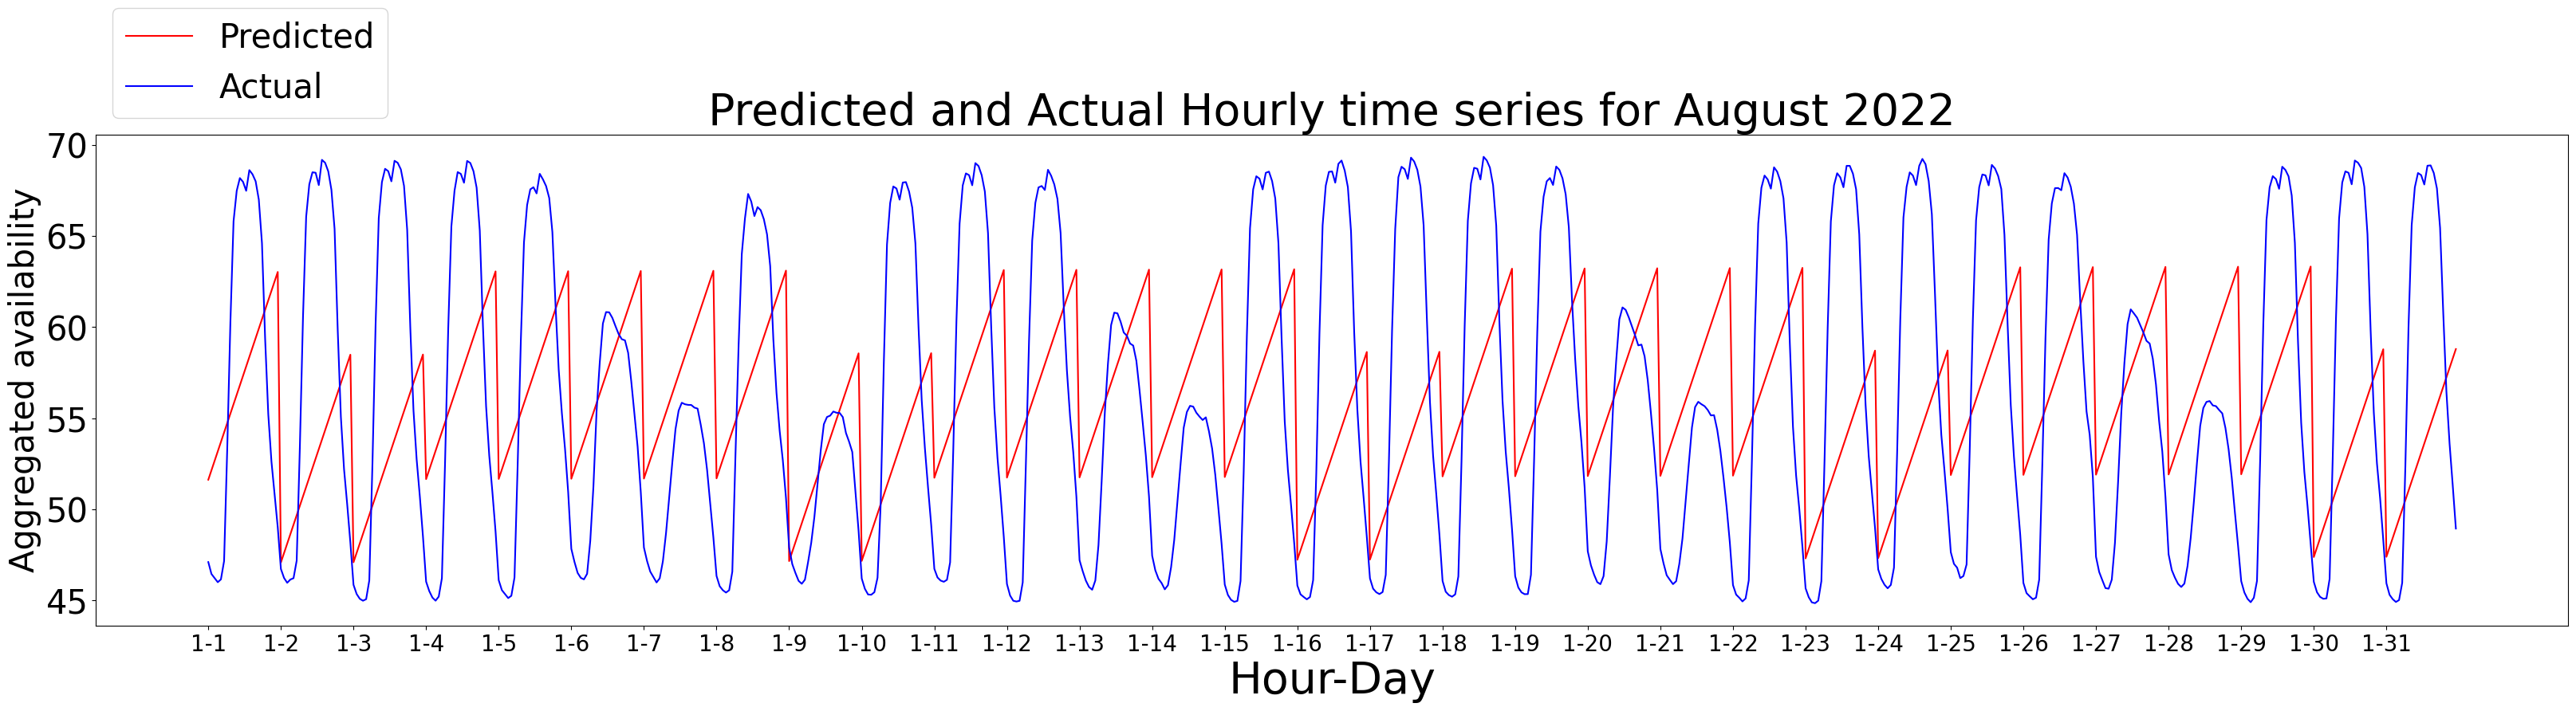

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40,8))
x = df_july.columns[1:].tolist()

plt.plot(x,Y_pred['PercentageAvailable'].to_list(),color='r',label='Predicted')
plt.plot(x,Y_test['PercentageAvailable'].to_list(),color='b',label='Actual')


plt.title("Predicted and Actual Hourly time series for August 2022", fontdict = {'fontsize' : 40})
plt.xlabel("Hour-Day",fontsize=40)
plt.ylabel("Aggregated availability",fontsize=30)
plt.xticks(x[::23],fontsize=20) #sets interval to daily, and increase fontsize for visibility
plt.yticks(fontsize=30)
plt.legend(bbox_to_anchor=(0, 1),loc="lower left",fontsize=30, ncol=1)
plt.show()

### Scatter-plot and Regression Line

Their is a large deviation between the predicted value and the actual of value of the test data. This shows that the linear regression model might not be a suitable model for this problem.

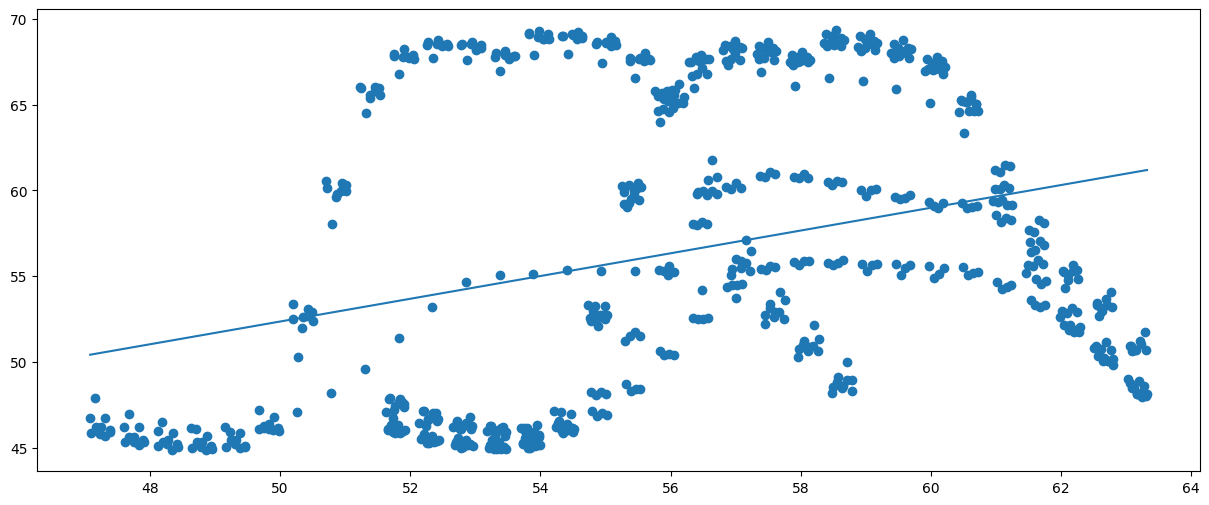

In [22]:
import numpy as np
plt.figure(figsize=(15,6))
plt.scatter(Y_pred,Y_test["PercentageAvailable"])
plt.plot(np.unique(Y_pred), np.poly1d(np.polyfit(Y_pred["PercentageAvailable"], Y_test["PercentageAvailable"], 1))(np.unique(Y_pred[["PercentageAvailable"]])))

### Question-2.3
Do the same as Question 2.2 above but use support vector regressor (SVR).

We now design our model based on SVR. First, let us define the train and test datasets. X is the features and Y is the label.

In [23]:
X_train = df_july_sum.drop('PercentageAvailable', axis = 1)
Y_train = df_july_sum['PercentageAvailable'].to_frame()
X_test = df_aug_sum.drop('PercentageAvailable', axis = 1)
Y_test = df_aug_sum['PercentageAvailable'].to_frame()

Let us check if we have the right datasets.

In [24]:
print("X_train:", X_train)
print("Y_train:", Y_train)
print("X_train:", X_test)
print("Y_train:", Y_test)

X_train:     hour day  Weekend
0      1   1        0
1      2   1        0
2      3   1        0
3      4   1        0
4      5   1        0
..   ...  ..      ...
708   19  31        1
709   20  31        1
710   21  31        1
711   22  31        1
712   23  31        1

[713 rows x 3 columns]
Y_train:      PercentageAvailable
0              46.590776
1              45.745673
2              45.430436
3              45.731024
4              45.680442
..                   ...
708            55.154848
709            53.984143
710            52.378241
711            50.714156
712            48.960241

[713 rows x 1 columns]
X_train:     hour day  Weekend
0      1   1        0
1      2   1        0
2      3   1        0
3      4   1        0
4      5   1        0
..   ...  ..      ...
708   19  31        1
709   20  31        1
710   21  31        1
711   22  31        1
712   23  31        1

[713 rows x 3 columns]
Y_train:      PercentageAvailable
0              47.101430
1             

By comparision, we have the dataset we want. Now let us define a random model to implement SVR. We will tune the hyperparameters later.

In [25]:
import numpy as np
from sklearn.svm import SVR
regressor = SVR(kernel='linear', C=50, degree=10)
regressor.fit(X_train, Y_train.values.ravel())

SVR(C=50, degree=10, kernel='linear')

Let us now get the predicted dataset df_pred.

In [26]:
y_pred = regressor.predict(X_test)
y_pred

array([47.42723033, 48.13772132, 48.84821231, 49.5587033 , 50.26919429,
       50.97968528, 51.69017626, 52.40066725, 53.11115824, 53.82164923,
       54.53214022, 55.24263121, 55.95312219, 56.66361318, 57.37410417,
       58.08459516, 58.79508615, 59.50557714, 60.21606812, 60.92655911,
       61.6370501 , 62.34754109, 63.05803208, 44.87335409, 45.58384508,
       46.29433606, 47.00482705, 47.71531804, 48.42580903, 49.13630002,
       49.84679101, 50.55728199, 51.26777298, 51.97826397, 52.68875496,
       53.39924595, 54.10973694, 54.82022792, 55.53071891, 56.2412099 ,
       56.95170089, 57.66219188, 58.37268287, 59.08317385, 59.79366484,
       60.50415583, 44.90409635, 45.61458734, 46.32507833, 47.03556932,
       47.74606031, 48.45655129, 49.16704228, 49.87753327, 50.58802426,
       51.29851525, 52.00900624, 52.71949722, 53.42998821, 54.1404792 ,
       54.85097019, 55.56146118, 56.27195217, 56.98244316, 57.69293414,
       58.40342513, 59.11391612, 59.82440711, 60.5348981 , 47.51

Now we plot the time series based on the prediction from our model. We plot the actual labels from the test set versus the training data label predictions.

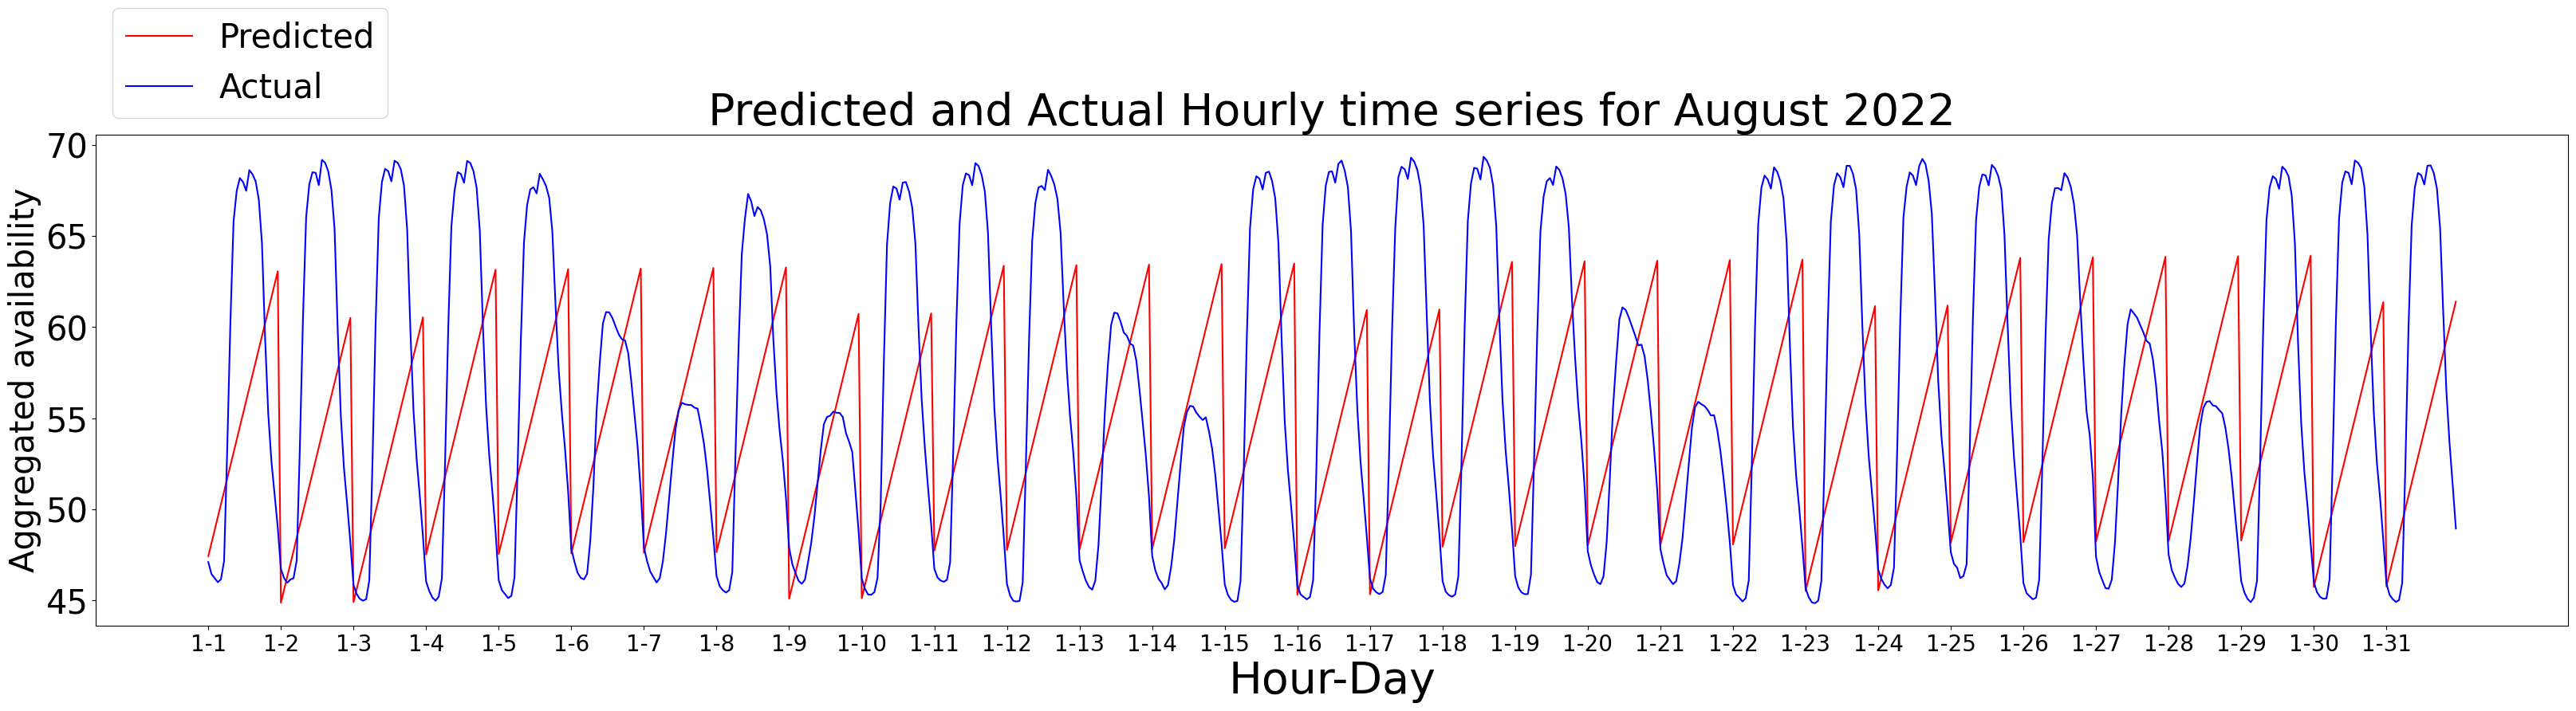

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40,8))
x = df_july.columns[1:].tolist()

plt.plot(x,y_pred,color='r',label='Predicted')
plt.plot(x,Y_test["PercentageAvailable"].to_list(),color='b',label='Actual')


plt.title("Predicted and Actual Hourly time series for August 2022", fontdict = {'fontsize' : 40})
plt.xlabel("Hour-Day",fontsize=40)
plt.ylabel("Aggregated availability",fontsize=30)
plt.xticks(x[::23],fontsize=20) #sets interval to daily, and increase fontsize for visibility
plt.yticks(fontsize=30)
plt.legend(bbox_to_anchor=(0, 1),loc="lower left",fontsize=30, ncol=1)
plt.show()

Now we get the scatter plot for the same. We plot the actual labels from the test set versus the training data label predictions.

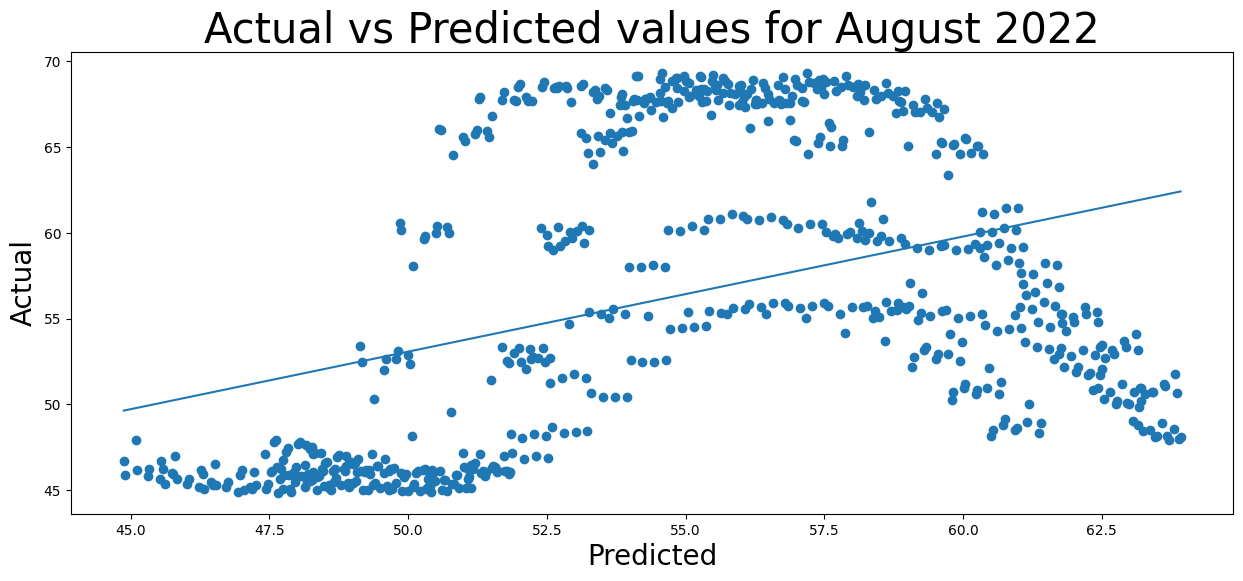

In [28]:
import numpy as np
plt.figure(figsize=(15,6))
plt.title("Actual vs Predicted values for August 2022", fontdict = {'fontsize' : 30})
plt.xlabel("Predicted",fontsize=20)
plt.ylabel("Actual",fontsize=20)
plt.scatter(y_pred,Y_test["PercentageAvailable"])
plt.plot(np.unique(y_pred), np.poly1d(np.polyfit(y_pred, Y_test["PercentageAvailable"], 1))(np.unique(y_pred)))
plt.show()

### Question-2.4
Do the same as Question 2.2 above but use decision tree (DT) regressor.

Let us get the train, test sets where X is the features and Y is the label.

In [29]:
X_train = df_july_sum.drop('PercentageAvailable', axis = 1)
Y_train = df_july_sum['PercentageAvailable'].to_frame()
X_test = df_aug_sum.drop('PercentageAvailable', axis = 1)
Y_test = df_aug_sum['PercentageAvailable'].to_frame()

Now let us define the Decision Tree model we use. Let us then get the set of predictions.

In [30]:
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor(random_state=44)
dt_model.fit(X_train, Y_train)
predictions = dt_model.predict(X_test)
predictions

array([46.5907756 , 45.74567326, 45.43043557, 45.73102389, 45.68044213,
       46.36536891, 52.93270553, 59.76483628, 65.13009601, 66.57209075,
       67.57349903, 67.55415081, 67.07486791, 68.08553569, 67.5893922 ,
       67.15778883, 66.4041759 , 64.60327178, 60.97548167, 57.72111208,
       55.24232947, 53.66351521, 51.11300601, 47.72458094, 46.77375442,
       46.19469002, 46.14410826, 46.0663008 , 46.48781546, 48.53734413,
       52.07419764, 55.79596479, 58.12797738, 60.01332263, 61.07968562,
       60.79526687, 60.48472804, 60.0467674 , 59.65994132, 59.39183035,
       59.45540306, 59.01910083, 57.69291897, 55.84654655, 54.17126763,
       51.54253636, 48.44060306, 47.29753822, 46.46058976, 46.40461814,
       46.17644742, 46.25950654, 47.22553522, 48.79578098, 50.83148949,
       52.59715222, 54.65497297, 55.60607589, 55.97203354, 55.84322971,
       55.59115013, 55.55134809, 55.69963833, 55.73405051, 55.08533253,
       54.024083  , 52.40795433, 50.67559817, 48.44751313, 46.12

Now we plot the time series based on the prediction from our model. We plot the actual labels from the test set versus the training data label predictions.

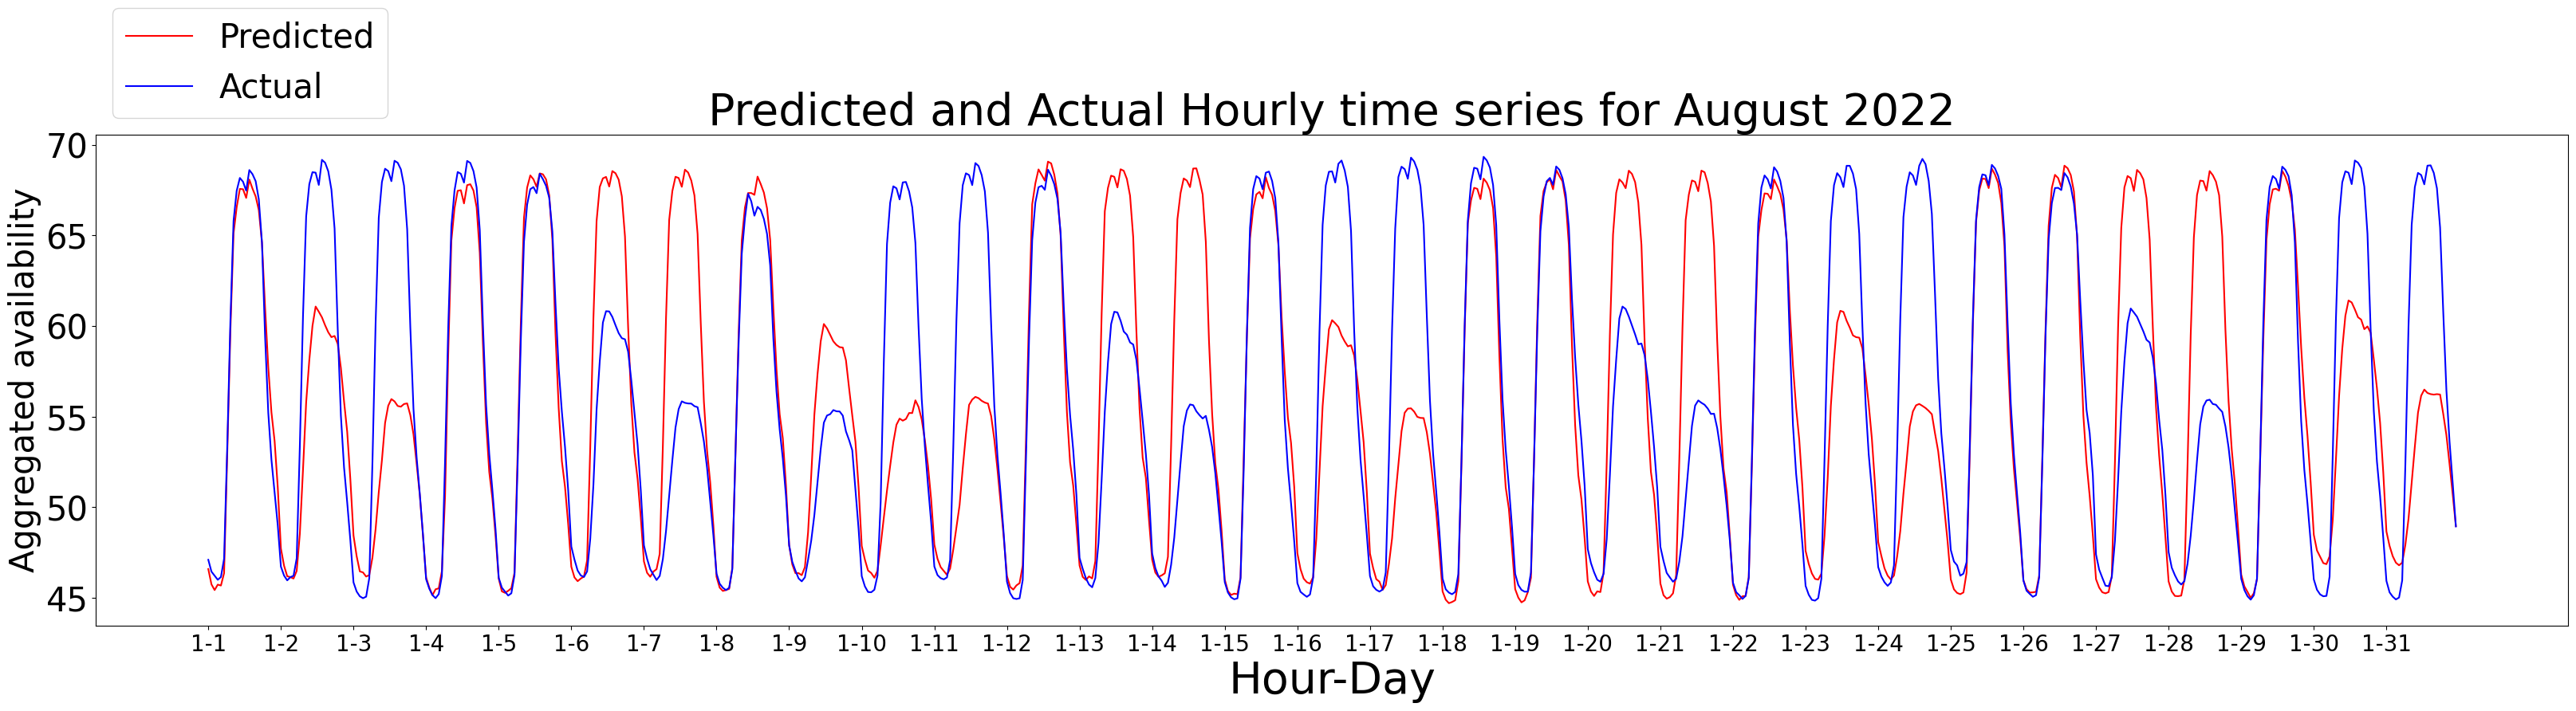

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40,8))
x = df_july.columns[1:].tolist()

plt.plot(x,predictions,color='r',label='Predicted')
plt.plot(x,Y_test["PercentageAvailable"].to_list(),color='b',label='Actual')


plt.title("Predicted and Actual Hourly time series for August 2022", fontdict = {'fontsize' : 40})
plt.xlabel("Hour-Day",fontsize=40)
plt.ylabel("Aggregated availability",fontsize=30)
plt.xticks(x[::23],fontsize=20) #sets interval to daily, and increase fontsize for visibility
plt.yticks(fontsize=30)
plt.legend(bbox_to_anchor=(0, 1),loc="lower left",fontsize=30, ncol=1)
plt.show()

Now we get the scatter plot for the same. We plot the actual labels from the test set versus the training data label predictions.

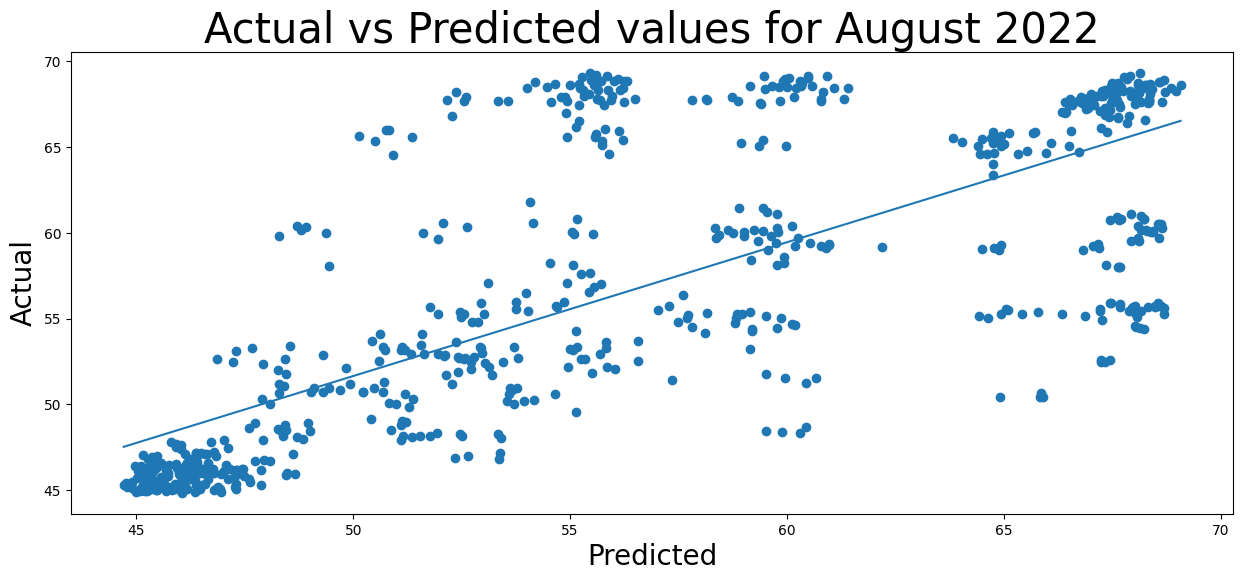

In [32]:
import numpy as np
plt.figure(figsize=(15,6))
plt.title("Actual vs Predicted values for August 2022", fontdict = {'fontsize' : 30})
plt.xlabel("Predicted",fontsize=20)
plt.ylabel("Actual",fontsize=20)
plt.scatter(predictions,Y_test["PercentageAvailable"])
plt.plot(np.unique(predictions), np.poly1d(np.polyfit(predictions, Y_test["PercentageAvailable"], 1))(np.unique(predictions)))
plt.show()

### Question-2.5
Make a final recommendation for the best regression model (out of the 3 methods above)
by choosing a suitable performance metric. To ensure a fair comparison, carry out hyperparameter
tuning for all 3 methods. Then, make a final recommendation selecting only
one model. Include both quantitative and qualitative arguments for your choice.

We import the mean_squared_error metric as a useful metric for comparision. 

In [33]:
from sklearn.metrics import mean_squared_error

def get_rmse(y_test, predictions): 
    return mean_squared_error(y_test, predictions, squared=False)

# Hyperparameter tuning

We will use GridSearchCV to help in the hyperparameter tuning. It uses cross-validation technique to find the optimal parameter values from a given set of parameters in a grid. 

In [34]:
from sklearn.model_selection import GridSearchCV

Let us now test each of the methods.

## Linear Regressor

There is no way to imporve the performance of the linear regression model apart from normalizing the data which is done by setting the normalize parameter of the linear regression model to true. Apart from that modifying other parameters of the linear regression model such as 'fit_interecept'and 'positive' do not make a significant improvement in model performance.

In [35]:
from sklearn.metrics import mean_squared_error
import math

MSE = mean_squared_error(Y_test,Y_pred)
RMSE = math.sqrt(MSE)

print(f'Mean squared error = {MSE}')
print(f'Root mean squared error = {MSE}')

Mean squared error = 69.86862289862506
Root mean squared error = 69.86862289862506


## SV Regressor

We obtain the optimal hyperparameters. (Note: This cell takes a long time to process. When we tried compiling it all of our mmodels into one notebook it caused takes a substantial amount of time to run)

In [ ]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid = GridSearchCV(regressor,param_grid,refit=True,verbose=2)
grid.fit(X_train,Y_train)
print(grid.best_estimator_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s


/Users/shreyaskumar/miniforge3/envs/cs3237_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shreyaskumar/miniforge3/envs/cs3237_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shreyaskumar/miniforge3/envs/cs3237_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shreyaskumar/miniforge3/envs/cs3237_env/lib/python3.8/site-packages/sklearn/utils/validation.py:111

We now get the accuracy of the optimum model.

accuracy = SVR_grid.best_score_ *100
The accuracy was calculated to be 75%.

We now run the model again with updated values.

In [38]:
regressor = SVR(C=10, degree=2, gamma=0.01, kernel='rbf')
regressor.fit(X_train, Y_train.values.ravel())
y_pred = regressor.predict(X_test)

We then obtain the RMSE for DT.

In [39]:
SVR_rmse = get_rmse(Y_test, y_pred)
SVR_rmse

4.696970437035105

## DT Regressor

We obtain the optimal hyperparameters.

In [39]:
params = {'max_leaf_nodes': list(range(2, 100)), 
          'min_samples_split': list(range(2, 10)),
          'max_depth': list(range(2, 10)),
          'criterion':["squared_error", "friedman_mse", "absolute_error", "poisson"]}
grid_search_cv = GridSearchCV(dt_model, params, verbose=1, cv=3,n_jobs= -1,return_train_score=True)
DT_grid = grid_search_cv.fit(np.array(X_train), Y_train)
DT_grid.best_estimator_

Fitting 3 folds for each of 25088 candidates, totalling 75264 fits


DecisionTreeRegressor(max_depth=3, max_leaf_nodes=7, random_state=44)

We now get the accuracy of the optimum model.

In [40]:
accuracy = DT_grid.best_score_ *100
accuracy

88.42463481112007

We now run the model again with updated values.

In [41]:
dt_model = DecisionTreeRegressor(max_depth=3, max_leaf_nodes=7, random_state=44)
dt_model.fit(X_train, Y_train)
predictions = dt_model.predict(X_test)
predictions

array([46.10988927, 46.10988927, 46.10988927, 46.10988927, 46.10988927,
       46.10988927, 52.51573836, 65.42927161, 65.42927161, 65.42927161,
       65.42927161, 65.42927161, 65.42927161, 65.42927161, 65.42927161,
       65.42927161, 65.42927161, 65.42927161, 65.42927161, 54.52370381,
       54.52370381, 50.62927391, 50.62927391, 46.10988927, 46.10988927,
       46.10988927, 46.10988927, 46.10988927, 46.10988927, 48.03496775,
       56.42839687, 56.42839687, 56.42839687, 56.42839687, 56.42839687,
       56.42839687, 56.42839687, 56.42839687, 56.42839687, 56.42839687,
       56.42839687, 56.42839687, 54.52370381, 54.52370381, 50.62927391,
       50.62927391, 46.10988927, 46.10988927, 46.10988927, 46.10988927,
       46.10988927, 46.10988927, 48.03496775, 56.42839687, 56.42839687,
       56.42839687, 56.42839687, 56.42839687, 56.42839687, 56.42839687,
       56.42839687, 56.42839687, 56.42839687, 56.42839687, 56.42839687,
       54.52370381, 54.52370381, 50.62927391, 50.62927391, 46.10

We then obtain the RMSE for DT.

In [42]:
DT_rmse = get_rmse(Y_test, predictions)
DT_rmse

5.718930486681499

Based on the optimum paramters, the model with the highest accuracy is DT and accuracy is a favourable metric over here because we are using the same propotion of data to compare different models, furthermore we choose this metric because the set is balanced i.e. we have the same hour-day data for both train and test.We did not go with SVR because the hyperparameterization does not cover all values. RMSE is usually a strong tool available to determine performance of regression models. Despite the RMSE value being lower in SVR, the difference is not statistically significant. Furthermore, the decision tree model also best fits the actual values, as shown from the graphs plotted above. It best follows the shape and patterns of the data from the month of August.